In [2]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score
from lightfm.cross_validation import random_train_test_split
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.decomposition import PCA

In [3]:
file = '../data/final_data_dict.pkl'
with open(file, 'rb') as f:
    data = pickle.load(f)

file = "../data/processed_step2/map_drug.pkl"
with open(file, 'rb') as f:
    drug_map = pickle.load(f)

file = "../data/processed_step2/map_disease.pkl"
with open(file, 'rb') as f:
    disease_map = pickle.load(f)

file = "../data/processed_step2/map_protein.pkl"
with open(file, 'rb') as f:
    protein_map = pickle.load(f)

## Create feature matrices

In [4]:
disease_prot_df = pd.read_csv("../data/processed_step1/Guney16_preprocessed.csv")
disease_prot_df = disease_prot_df.drop(["Unnamed: 0"], axis=1)
print(disease_prot_df.shape)
disease_prot_df.head()

(1448, 1023)


,MESHID,1,2,3,4,5,6,7,8,9,...,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022
0,D000012,4547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,D000013,374654,5820.0,9289.0,5824.0,4000.0,5828.0,3854.0,3852.0,3853.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,D000015,374654,1302.0,8626.0,2657.0,5190.0,2138.0,5192.0,5077.0,5824.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,D000052,2261,3643.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,D000130,2261,1280.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
num_proteins = len(protein_map)
disease_one_hot_matrix = np.zeros((len(disease_map), num_proteins), dtype=int)

for i in range(len(disease_prot_df)):
    disease = disease_prot_df['MESHID'][i]
    if(disease in disease_map):
        disease_index = disease_map[disease]
        for column in disease_prot_df.columns[1:]:
            protein = disease_prot_df[column][i]
            if(pd.isna(protein)==False):
                protein = int(protein)
                if(protein in protein_map):
                    protein_index = protein_map[protein]
                    disease_one_hot_matrix[disease_index, protein_index] = 1

disease_one_hot_df = pd.DataFrame(disease_one_hot_matrix, index=disease_map.keys(), columns=[f"protein_{i}" for i in range(num_proteins)])
disease_one_hot_df.head()

,protein_0,protein_1,protein_2,protein_3,protein_4,protein_5,protein_6,protein_7,protein_8,protein_9,...,protein_18495,protein_18496,protein_18497,protein_18498,protein_18499,protein_18500,protein_18501,protein_18502,protein_18503,protein_18504
D000012,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D000013,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D000015,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D000052,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D000130,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
drug_gene_df = pd.read_csv("../data/processed_step1/drug-gene.csv")
drug_gene_df = drug_gene_df.drop(["Unnamed: 0"], axis=1)
print(drug_gene_df.shape)
drug_gene_df.head()

(24649, 2)


,ID,entrez_id
0,DB00001,2147.0
1,DB00002,1956.0
2,DB00002,2215.0
3,DB00002,715.0
4,DB00002,712.0


In [7]:
num_proteins = len(protein_map)
drug_one_hot_matrix = np.zeros((len(drug_map), num_proteins), dtype=int)

for i in range(len(drug_gene_df)):
    drug = drug_gene_df['ID'][i]
    if(drug in drug_map):
        drug_index = drug_map[drug]
    protein = drug_gene_df['entrez_id'][i]
    if(pd.isna(protein)==False):
        protein = int(protein)
        if(protein in protein_map):
            protein_index = protein_map[protein]
            drug_one_hot_matrix[drug_index, protein_index] = 1

drug_one_hot_df = pd.DataFrame(drug_one_hot_matrix, index=drug_map.keys(), columns=[f"protein_{i}" for i in range(num_proteins)])
drug_one_hot_df.head()

,protein_0,protein_1,protein_2,protein_3,protein_4,protein_5,protein_6,protein_7,protein_8,protein_9,...,protein_18495,protein_18496,protein_18497,protein_18498,protein_18499,protein_18500,protein_18501,protein_18502,protein_18503,protein_18504
DB00001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DB00002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DB00004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DB00005,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DB00006,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
disease_drug_df = pd.read_csv("../data/processed_step1/original_disease_drug.tsv", sep="\t")
print(disease_drug_df.shape)
disease_drug_df.head()

(466657, 2)


,# Disease(MESH),Chemical
0,D005923,DB00564
1,D009503,DB01072
2,D016115,DB01759
3,D018476,DB00451
4,C567059,DB00641


In [9]:
disease_drug_adj = np.zeros((len(disease_one_hot_matrix), len(drug_one_hot_matrix)), dtype=int)

for i in range(len(disease_drug_df)):
    disease = disease_drug_df["# Disease(MESH)"][i]
    drug = disease_drug_df["Chemical"][i]
    if(disease in disease_map and drug in drug_map):
        disease_drug_adj[disease_map[disease], drug_map[drug]] = 1

print(disease_drug_adj.shape)
print(np.sum(disease_drug_adj))
print(disease_drug_adj)

(1448, 6158)
195811
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


## Matrix Factorization

In [30]:
dataset = Dataset()
num_diseases, num_drugs = disease_drug_adj.shape

dataset.fit(users=np.arange(num_diseases), items=np.arange(num_drugs),
            user_features=np.arange(disease_one_hot_matrix.shape[1]),
            item_features=np.arange(drug_one_hot_matrix.shape[1]))

(interactions, _) = dataset.build_interactions(((i, j) for i in range(num_diseases) for j in range(num_drugs) if disease_drug_adj[i, j] > 0))
user_features = dataset.build_user_features(((i, list(np.nonzero(disease_one_hot_matrix[i])[0])) for i in range(num_diseases)))
item_features = dataset.build_item_features(((i, list(np.nonzero(drug_one_hot_matrix[i])[0])) for i in range(num_drugs)))

train_interactions, test_interactions = random_train_test_split(interactions, test_percentage=0.2)

In [32]:
def track_metrics(model, train_interactions, test_interactions, user_features, item_features, num_epochs, num_threads=4, k=10):

    train_precision_per_epoch = []
    train_recall_per_epoch = []
    train_auc_per_epoch = []
    test_precision_per_epoch = []
    test_recall_per_epoch = []
    test_auc_per_epoch = []

    # train_dense_matrix = train_interactions.todense()
    # test_dense_matrix = test_interactions.todense()
    
    for epoch in range(num_epochs):
        model.fit_partial(train_interactions, user_features=user_features, item_features=item_features, epochs=1, num_threads=num_threads)

        train_auc = auc_score(model, train_interactions, user_features=user_features, item_features=item_features).mean()
        train_auc_per_epoch.append(train_auc)

        test_auc = auc_score(model, test_interactions, user_features=user_features, item_features=item_features).mean()
        test_auc_per_epoch.append(test_auc)

        if(epoch%2==0):
            print(f"Epoch {epoch + 1}/{num_epochs}: \t AUC: {train_auc:.4f}, {test_auc:.4f}")

    return train_precision_per_epoch, train_recall_per_epoch, train_auc_per_epoch, test_precision_per_epoch, test_recall_per_epoch, test_auc_per_epoch

model = LightFM(loss='logistic')
num_epochs = 25
# model.fit(interactions, user_features=user_features, item_features=item_features, epochs=30, num_threads=4)
train_precision_per_epoch, train_recall_per_epoch, train_auc_per_epoch, test_precision_per_epoch, test_recall_per_epoch, test_auc_per_epoch = track_metrics(model, train_interactions, test_interactions, user_features, item_features, num_epochs)


Epoch 1/25: 	 AUC: 0.8110, 0.8063
Epoch 3/25: 	 AUC: 0.8155, 0.8108
Epoch 5/25: 	 AUC: 0.8174, 0.8127
Epoch 7/25: 	 AUC: 0.8186, 0.8140
Epoch 9/25: 	 AUC: 0.8195, 0.8149
Epoch 11/25: 	 AUC: 0.8202, 0.8156
Epoch 13/25: 	 AUC: 0.8208, 0.8161
Epoch 15/25: 	 AUC: 0.8213, 0.8166
Epoch 17/25: 	 AUC: 0.8217, 0.8170
Epoch 19/25: 	 AUC: 0.8220, 0.8173
Epoch 21/25: 	 AUC: 0.8224, 0.8177
Epoch 23/25: 	 AUC: 0.8227, 0.8180
Epoch 25/25: 	 AUC: 0.8229, 0.8183


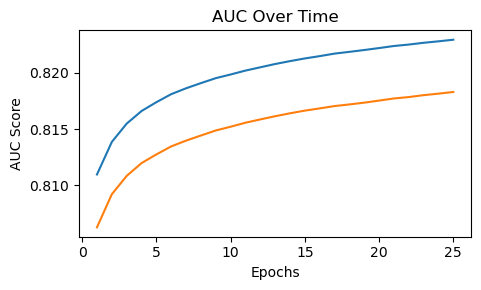

In [35]:
plt.figure(figsize=(5, 3))
plt.plot(range(1, num_epochs + 1), train_auc_per_epoch, label='Train')
plt.plot(range(1, num_epochs + 1), test_auc_per_epoch, label='Test')
plt.xlabel('Epochs')
plt.ylabel('AUC Score')
plt.title('AUC Over Time')
plt.tight_layout()
plt.show()

In [36]:
disease_map['D000086382']

1446

In [37]:
scores = model.predict(user_ids=1446, item_ids=np.arange(num_drugs), 
                           user_features=user_features, item_features=item_features)
top_drugs = np.argsort(-scores)[:20]

inverse_drug_map = {}
for key in drug_map:
    value = drug_map[key]
    inverse_drug_map[value] = key

top_drug_names = []
for drug in top_drugs:
    top_drug_names.append(inverse_drug_map[drug])
print(top_drug_names)

['DB14064', 'DB13975', 'DB14066', 'DB01263', 'DB08874', 'DB14063', 'DB06636', 'DB14065', 'DB14068', 'DB09291', 'DB00196', 'DB11431', 'DB01323', 'DB08873', 'DB12026', 'DB00607', 'DB01253', 'DB00845', 'DB01264', 'DB00778']


## Visualization

In [38]:
disease_embeddings = model.user_embeddings
drug_embeddings = model.item_embeddings

print(disease_embeddings)

[[ 0.03575742 -0.04204934 -0.02096132 ... -0.04147667 -0.04512467
  -0.02236674]
 [ 0.03397598  0.00391098  0.01759025 ...  0.00325507  0.0442514
  -0.04070966]
 [-0.04108414  0.01301369  0.03108565 ... -0.01973483 -0.03613259
  -0.03468665]
 ...
 [ 0.0027748  -0.01375563  0.04484262 ...  0.0139487   0.0059447
   0.0125622 ]
 [-0.03087539 -0.04027624  0.02215333 ... -0.02619998 -0.03820956
  -0.02644442]
 [-0.01253484 -0.00380572 -0.0467878  ... -0.01548894  0.01430416
   0.00841674]]


In [39]:
disease_embeddings = model.user_embeddings
drug_embeddings = model.item_embeddings

pca = PCA(n_components=2)
disease_embeddings_pca = pca.fit_transform(disease_embeddings)
drug_embeddings_pca = pca.fit_transform(drug_embeddings)

tsne = TSNE(n_components=2, random_state=42)
disease_embeddings_tsne = tsne.fit_transform(disease_embeddings)
drug_embeddings_tsne = tsne.fit_transform(drug_embeddings)

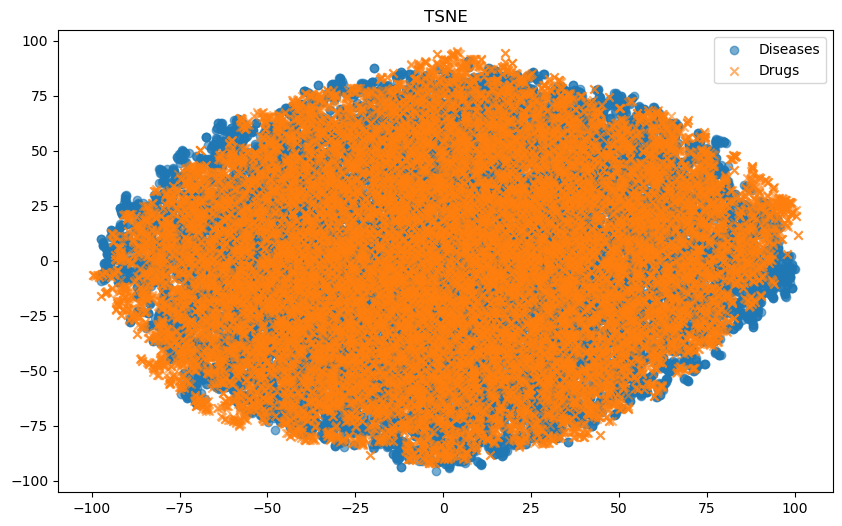

In [40]:
plt.figure(figsize=(10, 6))
plt.scatter(disease_embeddings_tsne[:, 0], disease_embeddings_tsne[:, 1], label='Diseases', alpha=0.6, marker='o')
plt.scatter(drug_embeddings_tsne[:, 0], drug_embeddings_tsne[:, 1], label='Drugs', alpha=0.6, marker='x')
plt.legend(loc='best')
plt.title('TSNE')
plt.show()

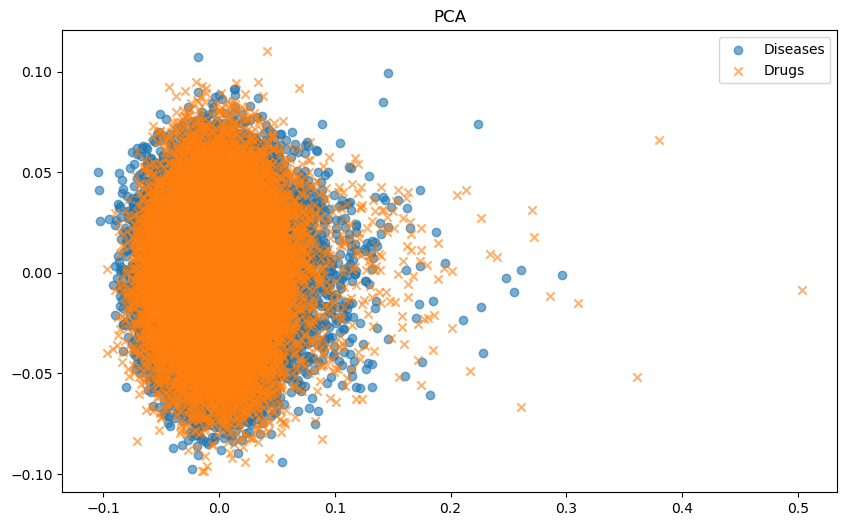

In [41]:
plt.figure(figsize=(10, 6))
plt.scatter(disease_embeddings_pca[:, 0], disease_embeddings_pca[:, 1], label='Diseases', alpha=0.6, marker='o')
plt.scatter(drug_embeddings_pca[:, 0], drug_embeddings_pca[:, 1], label='Drugs', alpha=0.6, marker='x')
plt.legend(loc='best')
plt.title('PCA')
plt.show()